# Tilt and Compliance Corrections for OBS Data: Continuous
### Xiaotao Yang @ Harvard University
This notebook contains examples of compliance corrections using local data on the disk. The functions for tilt and compliance corrections are in module seisgo.obsmaster.

## Step 0. Load needed packages.
Some functions are imported from the utils.py and the obsmaster.py.

In [6]:
#import needed packages.
from seisgo import utils
from seisgo import obsmaster as obs
import sys
import time
import scipy
import obspy
import pyasdf
import datetime
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from obspy import UTCDateTime
from obspy.core import Stream,Trace
from IPython.display import clear_output
from obspy.clients.fdsn import Client

## Step 1. Set global parameters
These parameters will control the downloading (optional) and tc-removing procedures.

In [7]:
"""
Set parameters for local data. This will be used by downloading and reading later.
"""
rawdatadir = '../data/raw'
if not os.path.isdir(rawdatadir): os.mkdir(rawdatadir)
#directory to save the data after TC removal
tcdatadir = '../data/tcremoval'
if not os.path.isdir(tcdatadir): os.mkdir(tcdatadir)
cleantartgetdir=True #change to False or remove/comment this block if needed.
dfiles0 = glob.glob(os.path.join(tcdatadir,'*.h5'))
if cleantartgetdir and len(dfiles0)>0:
    print('Cleaning up TC removal directory before running ...')
    for df0 in dfiles0:os.remove(df0)
        
"""
Tilt and compliance removal parameters
"""
window=3600
overlap=0.2
taper=0.08
qc_freq=[0.004, 1]
plot_correction=True
normalizecorrectionplot=True
tc_subset=['ZP-H']
#assemble all parameters into a dictionary.

Cleaning up TC removal directory before running ...


## Step 2 (optional). Download example data and save to disk
Set downloading and saving parameters. We download the same data as Figure 5 in Janiszewski et al. (2019).The following figure is from their paper for reference.
Earthquake information:
M 7.1 - Vanuatu
2012-02-02 13:34:40 (UTC)17.827°S 167.133°E 23.0 km depth

![title](embededfigs/JaniszewskiGJI2019Fig5.png)

We download all four components of the OBS data for the example stations.

In [8]:
downloaddata=False #change to False to save run time if the data has already been downloaded.
#remove previously save data files for this test.
if downloaddata:
    print('Cleaning up raw data directory before downloading ...')
    !rm ../data/*.h5
    #os.remove(rawdatadir+'/*.h5')
if downloaddata:
    """
    Parameters for downloading data.
    """
    client=Client('IRIS')
    # get data from IRIS web service
    net="7D"
    stalist=["FN07A","G30A"]#["G03A","J35A","J44A","J65A"]
    
    starttime = "2012_02_02_0_0_0"       
    endtime   = "2012_02_03_0_0_0"
    inc_hours = 8

    rmresp=True #remove instrument response
    # parameters for butterworth filter
    samp_freq=10
    pfreqmin=0.002
    pfreqmax=samp_freq/2

    # prefilter information used when removing instrument responses
    f1 = 0.95*pfreqmin;f2=pfreqmin
    if 1.05*pfreqmax > 0.48*samp_freq:
        f3 = 0.45*samp_freq
        f4 = 0.48*samp_freq
    else:
        f3 = pfreqmax
        f4= 1.05*pfreqmax
    pre_filt  = [f1,f2,f3,f4]


    # loop through datetime list.
    dtlist = utils.split_datetimestr(starttime,endtime,inc_hours)
    print(dtlist)
    for idt in range(len(dtlist)-1):     
        sdatetime = obspy.UTCDateTime(dtlist[idt])       
        edatetime   = obspy.UTCDateTime(dtlist[idt+1])

        fname = os.path.join(rawdatadir,dtlist[idt]+'T'+dtlist[idt+1]+'.h5')
        
        """
        Start downloading.
        """
        for ista in stalist:
            print('Downloading '+net+"."+ista+" ...")
            t0=time.time()
            """
            a. Download OBS data.
            """
            tr1,tr2,trZ,trP,sta_inv = obs.getobsdata(net,ista,sdatetime,edatetime,samp_freq=samp_freq,
                                          plot=False,rmresp=rmresp,pre_filt=pre_filt,getstainv=True)
            ta=time.time() - t0
            print('  downloaded '+net+"."+ista+" in "+str(ta)+" seconds.")
            """
            b. Save to ASDF file.
            """
            tags=[]
            for itr,tr in enumerate([tr1,tr2,trZ,trP],1):
                if len(tr.stats.location) == 0:
                    tlocation='00'
                else:
                    tlocation=tr.stats.location

                tags.append(tr.stats.channel.lower()+'_'+tlocation.lower())

            print('  saving to '+fname)
            utils.save2asdf(fname,Stream(traces=[tr1,tr2,trZ,trP]),tags,sta_inv=sta_inv)


## Step 3. Read local data and do correction
We use the wrapper function for tilt and compliance corrections.

Working on: ../data/raw/2012_02_04_00_00_00T2012_02_04_08_00_00.h5
  station: 7D.FN07A
['hdh_00', 'hh1_00', 'hh2_00', 'hhz_00']
  saving all component after TC removal to: ../data/tcremoval/2012_02_04_00_00_00T2012_02_04_08_00_00.h5
  station: 7D.G30A
['bdh_00', 'bh1_00', 'bh2_00', 'bhz_00']
  saving all component after TC removal to: ../data/tcremoval/2012_02_04_00_00_00T2012_02_04_08_00_00.h5


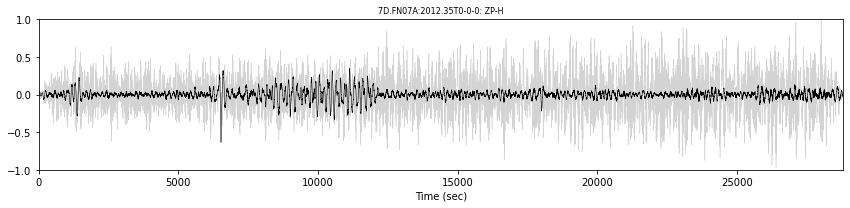

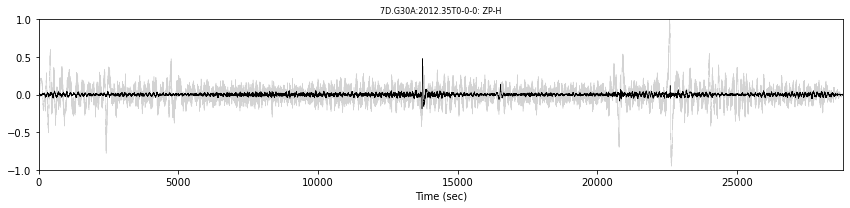

In [9]:
"""
Loop through all ASDF files.
steps:
a. read in file list
b. loop through all files
c. loop through all stations
    c-1. read waveform tags and list
    c-2. read station info if available. skip land stations or stations with only vertical.
    c-3. assemble all four components for OBS stations
    c-4. do correction work flow and plot the result if applicable
    c-5. save auxiliary data, e.g., tilt direction and angle, and TC removal parameters.
    c-6. save to original file name in different directory
"""
dfiles = glob.glob(os.path.join(rawdatadir,'*.h5'))
nfiles = len(dfiles)
splits  = nfiles
if nfiles==0:
    raise IOError('Abort! no available seismic files in '+rawdatadir)
    
for ifile in range(1):
    df=dfiles[ifile]
    print('Working on: '+df)
    dfbase=os.path.split(df)[-1]
    df_tc=os.path.join(tcdatadir,dfbase)
    
    ds=pyasdf.ASDFDataSet(df,mpi=False,mode='r') 
    netstalist = ds.waveforms.list()
    nsta = len(netstalist)


    for ista in netstalist:
        print('  station: '+ista)
        """
        TO-DO: get the four components"""
        try:
            inv = ds.waveforms[ista]['StationXML']
        except Exception as e:
            print('  No stationxml for %s in file %s'%(ista,df))
            inv = None

        all_tags = ds.waveforms[ista].get_waveform_tags()
        print(all_tags)
        if len(all_tags)<4:
            print("  Not enough components. Has to be four (4) channels! Skip!")
            continue

        tr1=None
        tr2=None
        trZ=None
        trP=None
        for tg in all_tags:
            if tg[2] == 'h': trP=ds.waveforms[ista][tg][0]
            elif tg[2] == '1' or tg[2] == 'e': tr1=ds.waveforms[ista][tg][0]
            elif tg[2] == '2' or tg[2] == 'n': tr2=ds.waveforms[ista][tg][0]
            elif tg[2] == 'z': trZ=ds.waveforms[ista][tg][0]
                
        spectra,transfunc,correct=obs.TCremoval_wrapper(
            tr1,tr2,trZ,trP,window=window,overlap=overlap,merge_taper=taper,
            qc_freq=qc_freq,qc_spectra=True,fig_spectra=False,
            save_spectrafig=False,fig_transfunc=False,correctlist=tc_subset)
        trZtc,tgtemp=obs.correctdict2stream(trZ,correct,tc_subset)

        if plot_correction:
            obs.plotcorrection(trZ,correct,normalize=normalizecorrectionplot,freq=[0.005,0.1],
                               size=(12,3),save=True,form='png')

        """
        Save to ASDF file.
        """
        tags=[]
        for tr in [tr1,tr2,trZtc[0],trP]:
            if len(tr.stats.location) == 0:
                tlocation='00'
            else:
                tlocation=tr.stats.location

            tags.append(tr.stats.channel.lower()+'_'+tlocation.lower())

        print('  saving all component after TC removal to: '+df_tc)
        utils.save2asdf(df_tc,Stream(traces=[tr1,tr2,trZtc[0],trP]),tags,sta_inv=inv)


In [29]:
spectra['rotation'].tilt

134.0